# Importing packages

In [1]:
import sys
sys.path.append('/home/gasanoe/fedmix_on_fedjax/src/')

In [2]:
from absl import app
import time

import fedjax
from fedjax.core import tree_util

import jax
import jax.numpy as jnp

import PLM
import itertools
import FedMix

2021-10-28 23:35:23.914784: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory


In [22]:
import pandas as pd

In [57]:
import pickle

# GridSearch

In [3]:
train_fd, test_fd = fedjax.datasets.emnist.load_data(only_digits=False, cache_dir='../data/')

Reusing cached file '/home/gasanoe/.cache/fedjax/federated_emnist_train.sqlite'
Reusing cached file '/home/gasanoe/.cache/fedjax/federated_emnist_test.sqlite'


In [4]:
fedjax.set_for_each_client_backend('pmap')

In [5]:
model = fedjax.models.emnist.create_conv_model(only_digits=False)

In [6]:
def loss(params, batch, rng):
    # `rng` used with `apply_for_train` to apply dropout during training.
    preds = model.apply_for_train(params, batch, rng)
    # Per example loss of shape [batch_size].
    example_loss = model.train_loss(batch, preds)
    return jnp.mean(example_loss)

In [7]:
grad_fn = jax.jit(jax.grad(loss))

In [8]:
def loss_for_eval(params, batch):
    preds = model.apply_for_eval(params, batch)
    example_loss = model.train_loss(batch, preds)
    return jnp.mean(example_loss)

In [9]:
grad_fn_eval = jax.jit(jax.grad(loss_for_eval))

In [10]:
lrs = 10**jnp.arange(-5, 1.5, 0.5) # learning rates
batch_sizes = [10, 20, 50, 100]

In [ ]:
# # For debugging purposes, we first run the code for smaller number of parameters
# lrs = [0.1, 0.01]
# batch_sizes = [10, 20]

In [11]:
num_epochs = 200
max_rounds_for_grid_search = 50
num_clients_per_round = 4

In [12]:
GridSearch_table = jnp.zeros(shape=(len(batch_sizes), len(lrs)))

In [ ]:
for b_id, batch_size in enumerate(batch_sizes):
    print('Batch size = {}'.format(batch_size))
    for lr_id, lr in enumerate(lrs):
        print('Learning rate = {}'.format(lr))
        client_sampler = fedjax.client_samplers.UniformShuffledClientSampler(shuffled_clients_iter=train_fd.clients(), num_clients=num_clients_per_round)
        client_optimizer = fedjax.optimizers.sgd(learning_rate=lr)
        client_batch_hparams = fedjax.ShuffleRepeatBatchHParams(batch_size=batch_size, num_epochs=num_epochs, drop_remainder=False)
        algorithm = PLM.computing_plm(grad_fn, client_optimizer, client_batch_hparams)
        # Initialize model parameters and algorithm server state.
        init_params = model.init(jax.random.PRNGKey(17))
        server_state = algorithm.init(init_params)
        rng = jax.random.PRNGKey(10)
        acc_grad_norm = 0
        for round_num in range(max_rounds_for_grid_search):
            print('Round {} / {}'.format(round_num + 1, max_rounds_for_grid_search), end='\r')
            clients = client_sampler.sample()
            server_state, _ = algorithm.apply(server_state, clients)
            for cid, cds, _ in clients:
                grad_eval = grad_fn_eval(server_state.PLM[cid], cds.all_examples())
                acc_grad_norm += tree_util.tree_l2_norm(grad_eval)
        acc_grad_norm /= num_clients_per_round * max_rounds_for_grid_search
        GridSearch_table = GridSearch_table.at[b_id, lr_id].set(acc_grad_norm)

Batch size = 10
Learning rate = 9.999999747378752e-06


In [18]:
GS_save_file_path = '../results/GridSearch_table_PLM_EMNIST.npy'

In [17]:
with open(GS_save_file_path, 'wb') as file:
    jnp.save(file, GridSearch_table)

In [19]:
with open(GS_save_file_path, 'rb') as file:
    GS_table = jnp.load(file)

In [25]:
df = pd.DataFrame(data=GridSearch_table, index=batch_sizes, columns=lrs)

In [26]:
df

,0.000010,0.000032,0.000100,0.000316,0.001000,0.003162,0.010000,0.031623,0.100000,0.316228,1.000000,3.162278,10.000000
10,0.867310,0.870549,1.125243,1.467449,1.274870,0.374492,0.110295,0.039057,0.006099,NaN,NaN,NaN,NaN
20,0.880320,0.858000,0.919690,1.340670,1.482529,0.986030,0.198914,0.085241,0.025094,0.002671,NaN,NaN,NaN
50,0.890215,0.876242,0.857571,0.966081,1.411649,1.408732,0.765323,0.171495,0.067144,0.019246,NaN,NaN,NaN
100,0.893815,0.886509,0.867329,0.870285,1.123945,1.468839,1.282055,0.400923,0.118202,0.035662,0.037071,NaN,NaN


# Computing pure local models for all clients

In [27]:
batch_size = 20
lr = 10 ** (-0.5)

In [47]:
client_sampler = fedjax.client_samplers.UniformShuffledClientSampler(shuffled_clients_iter=train_fd.clients(), num_clients=num_clients_per_round)
client_optimizer = fedjax.optimizers.sgd(learning_rate=lr)
client_batch_hparams = fedjax.ShuffleRepeatBatchHParams(batch_size=batch_size, num_epochs=num_epochs, drop_remainder=False)
algorithm = PLM.computing_plm(grad_fn, client_optimizer, client_batch_hparams)

In [48]:
# Initialize model parameters and algorithm server state.
init_params = model.init(jax.random.PRNGKey(10))
server_state = algorithm.init(init_params)

all_clients_eval_grad_norms = [] # we will use this list to see the distribution of gradient norms at computed solutions

In [49]:
max_possible_rounds = int(train_fd.num_clients() / num_clients_per_round) # all clients should be processed

In [50]:
max_possible_rounds

850

In [51]:
# max_possible_rounds = 2 # for debugging

In [ ]:
for round_num in range(max_possible_rounds):
    print('Round {} / {}'.format(round_num + 1, max_possible_rounds), end='\r')
    clients = client_sampler.sample()
    server_state, _ = algorithm.apply(server_state, clients)
    for cid, cds, _ in clients:
        grad_eval = grad_fn_eval(server_state.PLM[cid], cds.all_examples())
        all_clients_eval_grad_norms.append(tree_util.tree_l2_norm(grad_eval))

In [56]:
save_plm_file = '../results/PLM_EMNIST.pickle'

In [58]:
with open(save_plm_file, 'wb') as handle:
    pickle.dump(server_state.PLM, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
save_plm_stat_file = '../results/PLM_EMNIST_stat.pickle'

In [60]:
with open(save_plm_stat_file, 'wb') as handle:
    pickle.dump(all_clients_eval_grad_norms, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Statistics

In [54]:
from matplotlib import pyplot as plt

In [61]:
all_clients_eval_grad_norms = jnp.array(all_clients_eval_grad_norms)

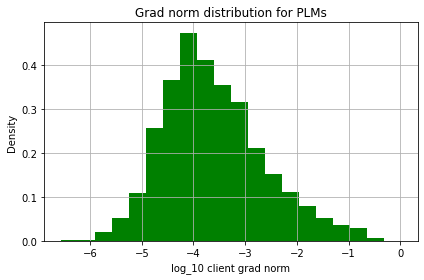

In [75]:
plt.hist(jnp.log10(all_clients_eval_grad_norms), bins=20, density=True, facecolor='g')
plt.grid()
plt.xlabel('log_10 client grad norm')
plt.ylabel('Density')
plt.title('Grad norm distribution for PLMs')
plt.tight_layout()
plt.savefig('../results/plots/EMNIST_grad_norm_distribution.pdf')